In [79]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
import torch
from pfl.data.dataset import Dataset

# Both Jupyter and `pfl` use async. `nest_asyncio` allows `pfl` to run inside the notebook 
import nest_asyncio
nest_asyncio.apply()

# append the root directory to your paths to be able to reach the examples.  
torch.random.manual_seed(1)
np.random.seed(1)

# Always import the `pfl` model first before initializing any `pfl` components to let `pfl` know which Deep Learning framework you will use.
import multiprocessing
# Set multiprocessing start method to "spawn" instead of forkserver (which is the default)
# That is because forkserver does not work on Windows, but spawn does.
def init_multiprocessing():
    try:
        multiprocessing.set_start_method("spawn", force=True)  # Forces "spawn"
    except RuntimeError:
        pass  # Ignore if it's already set

init_multiprocessing()

from pfl.model.pytorch import PyTorchModel

In [80]:
# Use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Parameters DPFL

Adjust these values as you please

In [81]:
from pfl.privacy import RDPPrivacyAccountant, CentrallyAppliedPrivacyMechanism, GaussianMechanism


# # Define Gaussian DP mechanisms for central DP guarantees using three different methods

# n_clients = 8                # Number of clients
# clipping_bound = 0.5         # Clipping bound for DP
# epsilon = 2                  # Epsilon parameter for DP
# delta = 1e-8                 # Delta parameter for DP
# sampling_probability = 1e-4  # Probability of a client being selected as cohort for a given iteration: cohort_size / n_clients
# is_central = True            # Probably delete this line in the future, as it is not used anywhere else in the code.

# # Other parameters for the training process

# local_learning_rate = 0.001  # Learning rate for local training
# local_num_epochs = 4         # Number of local epochs for each client
# local_batch_size = 32        # Batch size for local training
# central_num_iterations = 50  # Number of central iterations
# evaluation_frequency = 1     # How often to evaluate the model (in terms of central iterations)
# cohort_size = 8              # Number of clients in the cohort

# Define the DP mechanism

http://www.gautamkamath.com/CS860notes/lec5.pdf

Definition 5 on page 3 gives the definition of the parameters for Gaussian distribution where we sample noise for DP.

$\Delta_2^2$ is not included when defining `relative_noise_stddev`, because the clipping bound (which I understand to be $\Delta_2^2$ and also is $\Delta_2^{(f)}$ from definition 3 on page 3) is multiplied on `relative_noise_stddev`, when sampling the noise for DP via `GaussianMechanism.add_noise()`

Source: https://apple.github.io/pfl-research/reference/privacy.html#pfl.privacy.gaussian_mechanism.GaussianMechanism

Additionally, the issue here is how we select a good value of clipping bound. Normally, you set it to be the sensitivity $\Delta_2^{(f)}$ of function $f$ that aggregates on the dataset. But in our context of FL training, the function in question is the one that computes the gradients. Main problem with this is that the output gradient can be arbitrarily big, so the sensitiviy is in theory infinite. <br>
We need to figure out ourselves how to pick a good value for clipping bound.

In [82]:
# import math
# relative_noise_stddev = 2 * math.log(1.25 / delta) * 1/(epsilon**2)

PLD stands for privacy loss distribution.
A privacy accountant serves the purpose of reducing privacy leakage that is incurred from accessing the same data over the span of several central FL iterations.
As a result, it should give stronger privacy. It is based on the composability of Differential Privacy.

If you wish to use a privacy accountant attached to your DP mechanism, then you may uncomment the following code cell and then add `pld_central_privacy` as an element in `postprocessors` variable, which is found in the section 'Setting up the model'

A privacy accountant needs the following parameters when initialized:
- `num_compositions: int`: that is the total number of central iterations in FL training.
- `sampling_probability: float`: the probability that a user is chosen to be part of cohorts in a given iteration, i.e. `cohort_size / population`
- `mechanism: str`: specifies which noise mechanism to use. `'gaussian'` or `'laplace'` (according to source code, these are the only valid arguments).
- `epsilon: Optional[float]`: your desired DP parameter of your choice.
- `delta: Optional[float]`: your desired DP parameter of your choice.
- `noise_scale: float = 1.0`: I think this is multiplied on the sampled noise and the result is added to the gradient. By default, it is set to 1.0 and I think it would be best to not meddle with it.

Regarding to `epsilon` and `delta`, the privacy accountant will strive to apply the chosen `mechanism` during training while the privacy loss stays within the two privacy parameters. So `epsilon` and `delta` are our privacy budget that we choose freely.

## Privacy Loss Distribution Accountant

This one was from the `pfl-research` tutorial: https://colab.research.google.com/github/apple/pfl-research/blob/develop/tutorials/Introduction%20to%20Differential%20Privacy%20with%20Federated%20Learning.ipynb#scrollTo=o9o_TZL3JUp9

In [83]:
# # define a Gaussian DP mechanism using the PLD privacy accountant
# # WARNING: it takes a while for the gaussian_moments_accountant mechanism to be instantiated

# from pfl.privacy import (PLDPrivacyAccountant, CentrallyAppliedPrivacyMechanism, GaussianMechanism, LocalPrivacyMechanism)

# # define the PLD privacy accountant, which will use the Gaussian noise mechanism
# pld_accountant = PLDPrivacyAccountant(
#     num_compositions=num_epochs,
#     sampling_probability=sampling_probability,
#     mechanism='gaussian',
#     epsilon=epsilon,
#     delta=delta)

# # instantiate a Gaussian noise mechanism using the privacy accountant
# pld_gaussian_noise_mechanism = GaussianMechanism.from_privacy_accountant(
#     accountant=pld_accountant, clipping_bound=clipping_bound)

# # wrap the noise mechanism with CentrallyAppliedPrivacyMechanism to make it a central privacy mechanism
# pld_central_privacy = CentrallyAppliedPrivacyMechanism(pld_gaussian_noise_mechanism)

## Renyi Differential Privacy Accountant

Hannah recommends this accountant as a starter on involving DP.

In [84]:
# rdp_accountant = RDPPrivacyAccountant(
#     num_compositions=central_num_iterations,
#     sampling_probability=sampling_probability,
#     mechanism='gaussian',
#     epsilon=epsilon,
#     delta=delta
# )

# rdp_gaussian_noise_mechanism = GaussianMechanism.from_privacy_accountant(
#     accountant=rdp_accountant, clipping_bound=clipping_bound)

# # You then add this to the 'postprocessors' array instead of pld_central_privacy.
# rdp_central_privacy = CentrallyAppliedPrivacyMechanism(rdp_gaussian_noise_mechanism)

## Define a Local DP mechanism

https://apple.github.io/pfl-research/reference/privacy.html#pfl.privacy.gaussian_mechanism.GaussianMechanism

Below is an attempt to define our own custom DP mechanism.

In [85]:
# from pfl.metrics import Metrics

# class LocallyAppliedPrivacyMechanism(LocalPrivacyMechanism):

#     def privatize(self, statistics, name_formatting_fn=..., seed = None):
#         # TODO: Implement actual privatization for local DP
#         # TODO: Sample some noise (Gaussian: parameters depend on privacy parameters)
#         gaussian_mechanism = GaussianMechanism(clipping_bound=clipping_bound, 
#                                                relative_noise_stddev=relative_noise_stddev)
#         noisy_statistics, metrics = gaussian_mechanism.add_noise(statistics=statistics, 
#                                      cohort_size=cohort_size, 
#                                      name_formatting_fn=name_formatting_fn)
#         # TODO: Add the noise to statistics then send it
#         return noisy_statistics, metrics

Alternatively, we can try to use the implementation of privacy mechanisms that already exist in `pfl` module.

In [86]:
from pfl.privacy import GaussianMechanism, LaplaceMechanism
from torch.utils.data import TensorDataset

# Define the model

In [87]:
loss_fn = torch.nn.CrossEntropyLoss()

In [88]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Optional
from pfl.metrics import Weighted

class NetCIFAR(nn.Module):
    def __init__(self):
        super(NetCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        
        x = torch.flatten(x, 1)  # Flatten feature maps
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)
    

    def loss(self, inputs: torch.Tensor, targets: torch.Tensor, eval: bool = False) -> torch.Tensor:
        self.eval() if eval else self.train()
        return loss_fn(self(inputs), targets)

    @torch.no_grad()
    def metrics(self,
                inputs: torch.Tensor,
                targets: torch.Tensor,
                eval: bool = True) -> Dict[str, Weighted]:
        self.eval() if eval else self.train()
        prediction = self(inputs)
        logits = torch.argmax(prediction, dim=1)
        num_samples = len(inputs)
        # print(f"num_samples: {num_samples}")
        # print(f'targets: {targets}')
        # print(f'targets shape: {targets.shape}')
        # print(f'logits: {logits}')
        # print(f'logits shape: {logits.shape}')
        # print(f'prediction: {prediction}')
        # print(f'prediction shape: {prediction.shape}')
        # row_indices = torch.arange(targets.size(0))
        # correct_vector = targets[row_indices,logits]
        # print(f'correct_vector: {correct_vector}')
        # print(f'correct_vector shape: {correct_vector.shape}')

        # temp = torch.eq(logits, targets)
        # correct = torch.sum(correct_vector)

        # loss = loss_fn(prediction, targets).item()

        # Co-pilot fix
        if targets.ndim > 1:
            targets_indices = torch.argmax(targets, dim=1)
        else:
            targets_indices = targets
        correct = (logits == targets_indices).sum().item()
        loss = loss_fn(prediction, targets_indices).item()
        
        return {
            "loss": Weighted(loss, num_samples),
            "accuracy": Weighted(correct, num_samples)
        }


#pytorch_model = Net()




#pytorch_model.loss = loss
#pytorch_model.metrics = metrics

#pytorch_model.to(device)

In [89]:
# Alternative model from Ruben
class NetCIFAR_Abadi(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64,  kernel_size=5, padding=2)   # 4 800 + 64 = 4 864
        self.conv2 = nn.Conv2d(64,128, kernel_size=5, padding=2)   # 204 800 + 128 = 204 928
        self.pool  = nn.MaxPool2d(2)                               # keeps code tidy
        self.fc1   = nn.Linear(128*6*6, 192)                       # 884 736 + 192
        self.fc2   = nn.Linear(192,  64)                           # 12 288 + 64
        self.out   = nn.Linear(64,   10)                           # 640 + 10
        # ≈1 107 700 trainable parameters in total

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 24→12
        x = self.pool(F.relu(self.conv2(x)))   # 12→6
        x = torch.flatten(x, 1)                # 128 × 6 × 6 = 4 608 features
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)
    
    def loss(self, inputs: torch.Tensor, targets: torch.Tensor, eval: bool = False) -> torch.Tensor:
        self.eval() if eval else self.train()
        return loss_fn(self(inputs), targets)

    @torch.no_grad()
    def metrics(self,
                inputs: torch.Tensor,
                targets: torch.Tensor,
                eval: bool = True) -> Dict[str, Weighted]:
        self.eval() if eval else self.train()
        prediction = self(inputs)
        logits = torch.argmax(prediction, dim=1)
        num_samples = len(inputs)
        if targets.ndim > 1:
            targets_indices = torch.argmax(targets, dim=1)
        else:
            targets_indices = targets
        correct = (logits == targets_indices).sum().item()
        loss = loss_fn(prediction, targets_indices).item()
        
        return {
            "loss": Weighted(loss, num_samples),
            "accuracy": Weighted(correct, num_samples)
        }

In [90]:
class NetCIFARNew(nn.Module):
    def __init__(self):
        super(NetCIFARNew, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        
        x = torch.flatten(x, 1)  # Flatten feature maps
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

    def loss(self, inputs: torch.Tensor, targets: torch.Tensor, eval: bool = False) -> torch.Tensor:
        self.eval() if eval else self.train()
        return loss_fn(self(inputs), targets)

    @torch.no_grad()
    def metrics(self,
                inputs: torch.Tensor,
                targets: torch.Tensor,
                eval: bool = True) -> Dict[str, Weighted]:
        self.eval() if eval else self.train()
        prediction = self(inputs)
        logits = torch.argmax(prediction, dim=1)
        num_samples = len(inputs)
        if targets.ndim > 1:
            targets_indices = torch.argmax(targets, dim=1)
        else:
            targets_indices = targets
        correct = (logits == targets_indices).sum().item()
        loss = loss_fn(prediction, targets_indices).item()
        
        return {
            "loss": Weighted(loss, num_samples),
            "accuracy": Weighted(correct, num_samples)
        }

## Model for MNIST

In [91]:
class NetMNIST(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def loss(self, inputs: torch.Tensor, targets: torch.Tensor, eval: bool = False) -> torch.Tensor:
        self.eval() if eval else self.train()
        return loss_fn(self(inputs), targets)

    @torch.no_grad()
    def metrics(self,
                inputs: torch.Tensor,
                targets: torch.Tensor,
                eval: bool = True) -> Dict[str, Weighted]:
        self.eval() if eval else self.train()
        prediction = self(inputs)
        logits = torch.argmax(prediction, dim=1)
        num_samples = len(inputs)
        if targets.ndim > 1:
            targets_indices = torch.argmax(targets, dim=1)
        else:
            targets_indices = targets
        correct = (logits == targets_indices).sum().item()
        loss = loss_fn(prediction, targets_indices).item()
        
        return {
            "loss": Weighted(loss, num_samples),
            "accuracy": Weighted(correct, num_samples)
        }

## Wrapper function for instantiating the model

In [ ]:
def create_pytorch_model():
    pytorch_model = NetCIFARNew().to(device)
    pytorch_model.loss = pytorch_model.loss
    pytorch_model.metrics = pytorch_model.metrics
    return pytorch_model

# Preprocess the data

## Load the data

In [93]:
from pfl.data.dataset import Dataset
import torchvision
import torchvision.transforms as transforms


### CIFAR10

In [94]:
import torchvision.transforms as T

# def cifar_transforms(train: bool):
#     aug = [
#         T.RandomCrop(24),
#         T.RandomHorizontalFlip(),
#         T.ColorJitter(brightness=0.2, contrast=0.2),
#     ] if train else [T.CenterCrop(24)]

#     aug += [
#         T.ToTensor(),
#         # per‑image whitening (zero‑mean / unit‑var)
#         T.Lambda(lambda x: (x - x.mean((1,2), keepdim=True)) /
#                          (x.std((1,2), keepdim=True) + 1e-5)),
#     ]
#     return T.Compose(aug)

transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

batch_size = 32

trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


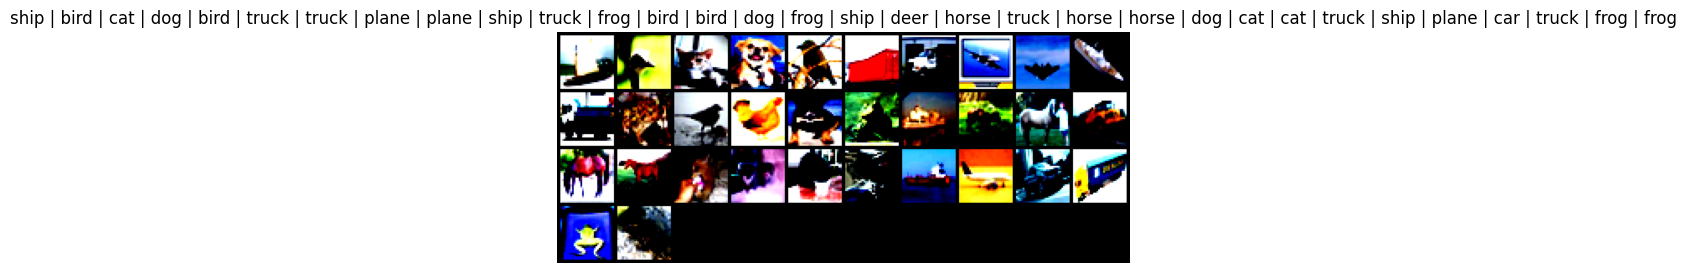

In [95]:
from torchvision import utils
dataiter = iter(trainloader_cifar)
images, labels = next(dataiter)

# Make a grid: one row
grid = utils.make_grid(images, nrow=10, padding=2)
img = grid.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]

# Plot
plt.figure(figsize=(12, 3))
plt.imshow(img)
plt.axis('off')
plt.title(" | ".join([classes[label] for label in labels]))
plt.show()

### MNIST

In [96]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Reformat the data

In [97]:
def dataloader_to_tensor_pair(dataloader):
    """
    Converts a PyTorch DataLoader to a pair of tensors (inputs, targets).
    Args:
        dataloader (torch.utils.data.DataLoader): The DataLoader to convert.
    
    Returns:
        tuple: A tuple containing two tensors: inputs and targets."""
    
    # print("dataloader_to_tensor_pair called")
    inputs, targets = [], []
    # i = 0
    # print("Starting to iterate over the dataloader")
    print(dataloader)
    for feature, label in dataloader:
        # print(f'Iteration {i}')
        # i += 1
        inputs.append(feature)
        targets.append(label)
    return torch.cat(inputs, dim=0), torch.cat(targets, dim=0)

In [98]:
# # Split the validation dataloader into features and labels
# val_all_features = []
# val_all_labels = []

# for features, labels in testloader:
#     val_all_features.append(features)
#     val_all_labels.append(labels)

# # Convert to tensors if needed
# val_all_features = torch.cat(val_all_features, dim=0).to(device)
# val_all_labels = torch.cat(val_all_labels, dim=0).to(device)


In [99]:
# print(val_all_features.shape)
# print(val_all_labels.shape)

In [ ]:
print("Calling dataloader_to_tensor_pair() to convert the train loader to tensors...")
train_features, train_labels = dataloader_to_tensor_pair(trainloader_cifar)
print("Calling dataloader_to_tensor_pair() to convert the test loader to tensors...")
val_features, val_labels = dataloader_to_tensor_pair(testloader_cifar)
print("Done converting dataloaders to tensors.")
central_data = Dataset(raw_data=[val_features, val_labels])

Calling dataloader_to_tensor_pair() to convert the train loader to tensors...
Calling dataloader_to_tensor_pair() to convert the test loader to tensors...
Done converting dataloaders to tensors.


In [101]:
# n_samples = len(trainloader.dataset)
# print(n_samples)
# val_n_samples = len(testloader.dataset)
# print(val_n_samples)

In [102]:
# Central data used for evaluating the central model at the server at each central iteration
# Just consists of the validation data
central_data = Dataset(raw_data=[val_features, val_labels])

# Train the model

## Processing the data

There are two ways of creating the federated dataset. You create an artificial federated dataset or just a normal federated dataset.

The difference between the two is that you want to use artificial federated dataset if your dataset does not provide user identifiers. These user identifiers are used to create an association between a user (participating in FL training) and their local dataset.

An example of a dataset that lacks user identifier is the CIFAR10 dataset. Therefore, it would be natural to instantiate an `ArtificialFederatedDataset`. One issue with this class from the `pfl` module is that you do not have any control over how many users there are in the dataset. The way `ArtificialFederatedDataset` works is that whenever you request a user dataset from it, the federated dataset samples a random subset of the original dataset and returns this subset on demand. This subset is an artificial user dataset <br>
On the other hand, you can decide how many data examples an artificial user by providing a callable parameter `sample_dataset_len`. It could be a lambda function that returns a constant, like 10 for instance. This means that every artificial user dataset will contain 10 data examples. Or you may do something a bit more complicated and sample a random number from a distribution of your choice. Then not all artificial user datasets will have the same number of examples.

### Creating artificial federated dataset

In [103]:
from pfl.data import ArtificialFederatedDataset, get_data_sampler

In [104]:
# # Create data sampler to sample each artificial user dataset as a random subset of the original dataset
# data_sampler = get_data_sampler(sample_type="minimize_reuse", max_bound=n_samples)

# # Create an artificial federated dataset where each user dataset has constant size such that there are 10 users to distribute among
# sample_dataset_len = lambda: int(n_samples/10)
# federated_dataset = ArtificialFederatedDataset.from_slices(
#     data=[all_features, all_labels], 
#     data_sampler=data_sampler,
#     sample_dataset_len=sample_dataset_len,
# )

In [105]:
# val_data_sampler = get_data_sampler(sample_type="minimize_reuse", max_bound=val_n_samples)

# # Create an artificial federated dataset where each user dataset has constant size such that there are of 10 users to distribute among
# val_sample_dataset_len = lambda: int(val_n_samples/10)
# val_federated_dataset = ArtificialFederatedDataset.from_slices(
#     data=[val_all_features, val_all_labels],
#     data_sampler=val_data_sampler,
#     sample_dataset_len=val_sample_dataset_len
# )

### Creating a federated dataset

For the purpose of being able to control the actual number of users, which `ArtificialFederatedDataset` does not allow

<strong>Reflection on designing `FederatedDataset`</strong>

How many datapoints should each user have?
- Every user has 50000/100 = 500 datapoints (easy approach)
- Alternatively, do some randomization on how many datapoints each user has (harder approach)

Should we use the exact same federated dataset in every FL experiment?
- The datapoint will be allocated to the same user in every experiment. This means that user 0 will have the exact same datapoints. User 1 will also have the exact same datapoints and so on... for every single time we run our experiment. This means our federated dataset will be exactly the same every time we run our experiment.

We decided to assume that all users have equally many datapoints and they will each possess the same datapoints every time we run our experiments.

In [106]:
from pfl.data import get_user_sampler, FederatedDataset

#### Training set (Fixed)
I must first decide how many users there are and then the method to how the data is distributed among the users.

In [107]:
# # Hyperparameter
# user_dataset_size = int(n_samples / n_clients)
# print(f'datapoints per user: {user_dataset_size}')

# # Maps user id to user dataset
# user_id_to_data = {}

# # Assign each user a dataset
# for i in range(n_clients):
#     start = i*user_dataset_size
#     end = start+user_dataset_size
#     features = train_all_features[start:end]
#     labels = train_all_labels[start:end]
#     user_id_to_data[i] = (features, labels)

# user_ids = list(user_id_to_data.keys())

# user_sampler = get_user_sampler(sample_type="random", user_ids=user_ids)

In [108]:
# federated_dataset = FederatedDataset.from_slices(
#     data=user_id_to_data,
#     user_sampler=user_sampler)

In [109]:
# Encapsulate the above code in a function

def create_fixed_federated_dataset(
    n_clients: int,
    user_dataset_size: int,
    train_all_features: torch.Tensor,
    train_all_labels: torch.Tensor
) -> FederatedDataset:
    """
    Create a fixed federated dataset with a given number of clients and dataset size.
    
    Args:
        n_clients (int): Number of clients.
        user_dataset_size (int): Size of each user's dataset.
        train_all_features (torch.Tensor): All training features.
        train_all_labels (torch.Tensor): All training labels.
        
    Returns:
        FederatedDataset: The created federated dataset.
    """
    user_id_to_data = {}
    
    for i in range(n_clients):
        start = i * user_dataset_size
        end = start + user_dataset_size
        features = train_all_features[start:end]
        labels = train_all_labels[start:end]
        user_id_to_data[i] = (features, labels)

    user_ids = list(user_id_to_data.keys())
    user_sampler = get_user_sampler(sample_type="random", user_ids=user_ids)

    return FederatedDataset.from_slices(
        data=user_id_to_data,
        user_sampler=user_sampler
    )

#### Training set (Random)

Testing cells for shuffling torch tensors

In [110]:
# tensor = torch.tensor([
#     [1, 2, 3],
#     [4, 5, 6],
#     [7, 8, 9]
# ])

In [111]:
# rand_indices = torch.randperm(tensor.size(0))
# rand_indices

In [112]:
# shuffled = tensor[rand_indices]
# shuffled

Actual creation of random `FederatedDataset`

In [113]:
# # Hyperparameter
# user_dataset_size = int(n_samples / n_clients)
# print(f'datapoints per user: {user_dataset_size}')

# # Maps user id to user dataset
# user_id_to_data = {}

# # Randomly shuffle the dataset
# rand_indices = torch.randperm(n_samples)
# shuffled_features = train_all_features[rand_indices]
# shuffled_labels = train_all_labels[rand_indices]

# # Assign each user a dataset
# for i in range(n_clients):
#     start = i*user_dataset_size
#     end = start+user_dataset_size
#     features = shuffled_features[start:end]
#     labels = shuffled_labels[start:end]
#     user_id_to_data[i] = (features, labels)

# user_ids = list(user_id_to_data.keys())

# user_sampler = get_user_sampler(sample_type="random", user_ids=user_ids)

In [114]:
# federated_dataset = FederatedDataset.from_slices(
#     data=user_id_to_data,
#     user_sampler=user_sampler)

In [115]:
# Encapsulate the above code in a function

def create_random_federated_dataset(
    n_clients: int,
    user_dataset_size: int,
    train_all_features: torch.Tensor,
    train_all_labels: torch.Tensor
) -> FederatedDataset:
    """
    Create a random federated dataset with a given number of clients and dataset size.
    
    Args:
        n_clients (int): Number of clients.
        user_dataset_size (int): Size of each user's dataset.
        train_all_features (torch.Tensor): All training features.
        train_all_labels (torch.Tensor): All training labels.
        
    Returns:
        FederatedDataset: The created federated dataset.
    """
    user_id_to_data = {}
    
    # Randomly shuffle the dataset
    rand_indices = torch.randperm(train_all_features.size(0))
    shuffled_features = train_all_features[rand_indices]
    shuffled_labels = train_all_labels[rand_indices]

    # Assign each user a dataset
    for i in range(n_clients):
        start = i * user_dataset_size
        end = start + user_dataset_size
        features = shuffled_features[start:end]
        labels = shuffled_labels[start:end]
        user_id_to_data[i] = (features, labels)

    user_ids = list(user_id_to_data.keys())
    user_sampler = get_user_sampler(sample_type="random", user_ids=user_ids)

    return FederatedDataset.from_slices(
        data=user_id_to_data,
        user_sampler=user_sampler
    )

#### Validation set

In [116]:
from typing import Tuple, Iterable
from pfl.data.dataset import AbstractDataset
from pfl.data.federated_dataset import FederatedDatasetBase

# Define my own custom Federated Dataset class for validation data

"""
    I did not see any reason to distribute validation data among users.
    Unfortunately, the pfl module does not provide a fitting implementation of
    a FederatedDataset for validation data. Therefore, I created my own class
    that simply returns the validation data as is.
"""
class ValidationFederatedDataset(FederatedDatasetBase):

    def __init__(self, dataset: Dataset):
        self.dataset = dataset

    def __next__(self) -> Tuple[AbstractDataset, int]:
        return Tuple(self.dataset, 0)
    
    def get_cohort(self, cohort_size: int) -> Iterable[Tuple[AbstractDataset, int]]:
        return [(self.dataset, 0)]


In [117]:
# val_federated_dataset = ValidationFederatedDataset(Dataset([val_all_features, val_all_labels]))

## Debugging cell

In [118]:
# import importlib
# import pfl.data.dataset

# importlib.reload(pfl.data.dataset)

# from pfl.data.dataset import Dataset

# cohorts = federated_dataset.get_cohort(1)
# print(f'cohorts: {cohorts}')
# user_dataset, _ = next(cohorts)
# print(f'user_dataset: {user_dataset}')
# len(user_dataset)

## Setting up the model

In [119]:
# params = [p for p in pytorch_model.parameters() if p.requires_grad]

# model = PyTorchModel(pytorch_model, 
#                      local_optimizer_create=torch.optim.Adam,
#                      central_optimizer=torch.optim.Adam(params, lr=0.001, weight_decay=1e-5))

In [120]:
from pfl.algorithm import FederatedAveraging, NNAlgorithmParams
from pfl.callback import CentralEvaluationCallback, AggregateMetricsToDisk
from pfl.hyperparam import NNTrainHyperParams, NNEvalHyperParams
from pfl.aggregate.simulate import SimulatedBackend


# model_train_params = NNTrainHyperParams(
#     local_learning_rate=local_learning_rate,
#     local_num_epochs=local_num_epochs,
#     local_batch_size=local_batch_size)

# # Do full-batch evaluation to run faster.
# model_eval_params = NNEvalHyperParams(local_batch_size=None)

# algorithm_params = NNAlgorithmParams(
#     central_num_iterations=central_num_iterations,
#     evaluation_frequency=evaluation_frequency,
#     train_cohort_size=cohort_size,
#     val_cohort_size=1)

# pfl_callbacks = [CentralEvaluationCallback(central_data, model_eval_params, evaluation_frequency),
#                   AggregateMetricsToDisk(output_path='pfl_training_metrics/metrics.csv')] # Save the metrics to a CSV file

# # Add the privacy mechanism to the training process
# # If you do not want to add privacy, simply leave 'postprocessors' empty
# postprocessors = [rdp_central_privacy]

# pfl_simulated_backend = SimulatedBackend(
#     training_data=federated_dataset,
#     val_data=val_federated_dataset,
#     postprocessors=postprocessors
# )


algorithm = FederatedAveraging()

## Run the training

In [121]:
# pfl_model = algorithm.run(
#     backend=pfl_simulated_backend,
#     model=model,
#     algorithm_params=algorithm_params,
#     model_train_params=model_train_params,
#     model_eval_params=model_eval_params,
#     callbacks=pfl_callbacks,
#     send_metrics_to_platform=True)

# Plot the metrics

In [122]:
# import pandas as pd
# import matplotlib.pyplot as plt

# metrics = pd.read_csv('pfl_training_metrics/metrics.csv')
# metrics = metrics.dropna(subset=['Central val | accuracy'])

In [123]:
# plt.plot(metrics['central_iteration'], metrics['Central val | accuracy'], label='Central Validation Accuracy')
# plt.xlabel('Central Iteration')
# plt.ylabel('Accuracy')

# Experimentation

The sections "Setting up the model", "Run the training" and "Plot the metrics" should demonstrate a single instance of a Federated Learning training.

However, we as researchers wish to run a particular training several times and take the average of the accuracy of each training instance. The following code should do that.

In [124]:
# Define Gaussian DP mechanisms for central DP guarantees using three different methods

n_clients = 8                                  # Number of clients
n_samples = len(trainset_cifar)           # Number of training samples
user_dataset_size = int(n_samples / n_clients) # Size of each user's dataset
clipping_bound = 0.5                           # Clipping bound for DP
epsilon = 7                                    # Epsilon parameter for DP
delta = 1e-5                                   # Delta parameter for DP
is_central = True                              # Probably delete this line in the future, as it is not used anywhere else in the code.

# Other parameters for the training process

local_learning_rate = 0.001                    # Learning rate for local training
local_num_epochs = 4                           # Number of local epochs for each client
local_batch_size = 32                          # Batch size for local training
central_num_iterations = 100                    # Number of central iterations
evaluation_frequency = 1                       # How often to evaluate the model (in terms of central iterations)
cohort_size = 8                                # Number of clients in the cohort
sampling_probability = cohort_size / n_clients # Probability of a client being selected as cohort for a given iteration: cohort_size / n_clients
"""
Note that the sampling probability affects the computation of noise scale by the privacy accountant.
When n_clients is bigger than cohort_size, then noise_scale becomes smaller.
You can observe this by letting n_clients be bigger, compute the new sampling_probability and then
see what the accountant computes as noise scale.
"""


# Choose the number of FL training instances
no_of_training : int = 5

# Choose a name for the training metrics file
training_name = "pfl_centralized_fixed_metrics_test"

In [125]:
def create_pfl_model():
    model = create_pytorch_model()
    params = [p for p in model.parameters() if p.requires_grad]
    return PyTorchModel(model,
                        local_optimizer_create=torch.optim.SGD,
                        central_optimizer=torch.optim.SGD(params, lr=local_learning_rate, weight_decay=1e-5))

In [126]:
# '''
# params = [p for p in pytorch_model.parameters() if p.requires_grad]

# model = PyTorchModel(pytorch_model, 
#                      local_optimizer_create=torch.optim.Adam,
#                      central_optimizer=torch.optim.Adam(params, lr=local_learning_rate, weight_decay=1e-5))
# '''
                     
# model_train_params = NNTrainHyperParams(
#     local_learning_rate=local_learning_rate,
#     local_num_epochs=local_num_epochs,
#     local_batch_size=local_batch_size)

# # Do full-batch evaluation to run faster.
# model_eval_params = NNEvalHyperParams(local_batch_size=None)

# algorithm_params = NNAlgorithmParams(
#     central_num_iterations=central_num_iterations,
#     evaluation_frequency=evaluation_frequency,
#     train_cohort_size=cohort_size,
#     val_cohort_size=1)

In [127]:
federated_dataset = create_random_federated_dataset(
            n_clients=n_clients,
            user_dataset_size=user_dataset_size,
            train_all_features=train_features,
            train_all_labels=train_labels
        )

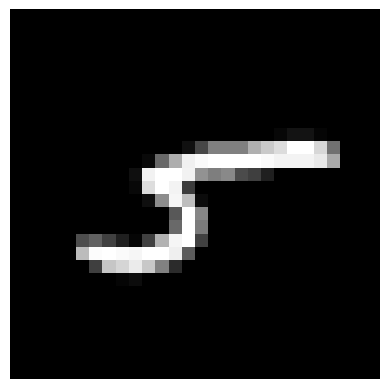

In [134]:
import matplotlib.pyplot as plt
import torch

# Get the raw data tensor (first image)
img_tensor = federated_dataset.make_dataset_fn(0).raw_data[0][1]  # [0] for the first image

# If MNIST (single channel), squeeze and plot as grayscale
if img_tensor.shape[0] == 1:
    plt.imshow(img_tensor.squeeze().cpu().numpy(), cmap='gray')
else:
    # If CIFAR (3 channels), permute to HWC and plot as RGB
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    # Undo normalization if needed
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.247, 0.243, 0.261]
    img = img * std + mean
    plt.imshow(img)

plt.axis('off')
plt.show()

In [ ]:

def run_experiements(no_of_training: int, training_name: str, n_clients: int, user_dataset_size: int, 
                     is_random_dataset: bool = True, postprocessors: list = []):
    """

    Args:
        no_of_training (int): Number of training instances to run.
        training_name (str): Name for the training metrics file.
        n_clients (int): Number of clients.
        user_dataset_size (int): Size of each user's dataset.
        is_random_dataset (bool): Whether to use a random dataset or a fixed dataset.
        postprocessors (list): List of postprocessors to apply during training. This is used to add the privacy mechanism. By default, there is no privacy mechanism.
    """

    create_federated_dataset = create_random_federated_dataset if is_random_dataset else create_fixed_federated_dataset

    for i in range(no_of_training):
        # Initialize the model for each training instance
        model = create_pfl_model()

        # Create a new federated dataset
        # Either use create_fixed_federated_dataset or create_random_federated_dataset depending on your needs
        federated_dataset = create_federated_dataset(
            n_clients=n_clients,
            user_dataset_size=user_dataset_size,
            train_all_features=train_features,
            train_all_labels=train_labels
        )

        # Create a new validation federated dataset
        val_federated_dataset = ValidationFederatedDataset(Dataset(raw_data=[val_features, val_labels]))


        model_train_params = NNTrainHyperParams(
            local_learning_rate=local_learning_rate,
            local_num_epochs=local_num_epochs,
            local_batch_size=local_batch_size)

    # Do full-batch evaluation to run faster.
        model_eval_params = NNEvalHyperParams(local_batch_size=None)

        algorithm_params = NNAlgorithmParams(
            central_num_iterations=central_num_iterations,
            evaluation_frequency=evaluation_frequency,
            train_cohort_size=cohort_size,
            val_cohort_size=1)

        pfl_callbacks = [CentralEvaluationCallback(central_data, model_eval_params, evaluation_frequency),
                    AggregateMetricsToDisk(output_path=f'experimental_results/{training_name}/metrics_{i}.csv')] # Save the metrics to a CSV file


        # Run the training process again with the new datasets
        pfl_simulated_backend = SimulatedBackend(
            training_data=federated_dataset,
            val_data=val_federated_dataset,
            postprocessors=postprocessors
        )

        algorithm.run(
            backend=pfl_simulated_backend,
            model=model,
            algorithm_params=algorithm_params,
            model_train_params=model_train_params,
            model_eval_params=model_eval_params,
            callbacks=pfl_callbacks,
            send_metrics_to_platform=True)

In [164]:
# # This cell is used to define the privacy mechanism for the training process

# rdp_accountant = RDPPrivacyAccountant(
#     num_compositions=central_num_iterations,
#     sampling_probability=sampling_probability,
#     mechanism='gaussian',
#     epsilon=epsilon,
#     delta=delta,
# )

# # The mechanism created by the accountant that automatically computes the noise scale based on the privacy parameters
# rdp_gaussian_noise_mechanism = GaussianMechanism.from_privacy_accountant(
#     accountant=rdp_accountant, clipping_bound=clipping_bound)

# # This line wraps the noise mechanism with CentrallyAppliedPrivacyMechanism to make it a central privacy mechanism
# rdp_central_privacy = CentrallyAppliedPrivacyMechanism(rdp_gaussian_noise_mechanism)

# rdp_gaussian_noise_mechanism.relative_noise_stddev

### Local Privacy Mechanism

Privacy accountant for computing noise scale

In [165]:
rdp_accountant = RDPPrivacyAccountant(
    num_compositions=central_num_iterations,
    sampling_probability=sampling_probability,
    mechanism='gaussian',
    epsilon=epsilon,
    delta=delta
)

# Noise scale computed by the RDP accountant
noise_scale=rdp_accountant.noise_parameter
noise_scale

7.137298583984375

In [166]:
from pfl.privacy import LocalPrivacyMechanism, GaussianMechanism

class MyLocalGaussianMechanism(LocalPrivacyMechanism):
    def __init__(self, clipping_bound, relative_noise_stddev):
        self.mechanism = GaussianMechanism(clipping_bound=clipping_bound, relative_noise_stddev=relative_noise_stddev)

    def privatize(self, statistics, name_formatting_fn=None, seed=None):
        # Add noise to the statistics (model updates) locally
        noisy_statistics, metrics = self.mechanism.add_noise(
            statistics=statistics,
            cohort_size=1,  # cohort_size=1 for local mechanism
            name_formatting_fn=name_formatting_fn
        )
        return noisy_statistics, metrics

# Example usage:
local_privacy = MyLocalGaussianMechanism(clipping_bound=clipping_bound, relative_noise_stddev=noise_scale)
# Then add local_privacy to the 'postprocessors' array to enable local DP

### Run the experiment

In [ ]:
run_experiements(no_of_training, training_name, n_clients, user_dataset_size, 
                 is_random_dataset=True, postprocessors=[local_privacy])

c:\Users\Tjalfe\anaconda3\envs\masters\lib\site-packages\pfl\internal\ops\pytorch_ops.py:342: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(v, device=get_default_device()).add(


Metrics at iteration 0 ():
    Central val | loss                                : 0.00023051016330718994
    Central val | accuracy                            : 0.0877
    Central val | number of data points               : 10000
    Train population | number of devices              : 8
    Train population | number of data points          : 6250.0
    Train population | loss before local training     : 0.000368846697807312
    Train population | accuracy before local training : 0.08994
    Train population | loss after local training      : 0.00036745314598083496
    Train population | accuracy after local training  : 0.12184
    Local DP | DP noise std. dev.                     : 3.5686492919921875
    Local DP | signal-to-DP-noise ratio               : 6.05803450192339e-05
    Train population | total weight                   : 1.0
    Number of parameters                              : 1107722
    Val population | number of devices                : 1
    Val population | number of